In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import libs

In [ ]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras import layers
from keras import metrics

import os
import random

2024-05-28 00:53:44.381363: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 00:53:44.381468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 00:53:44.538368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load data and preprocess data

## Show data info

In [ ]:
img_array = cv2.imread('../input/mrl-eye-dataset/data/train/close eyes/s0001_00001_0_0_0_0_0_01.png')

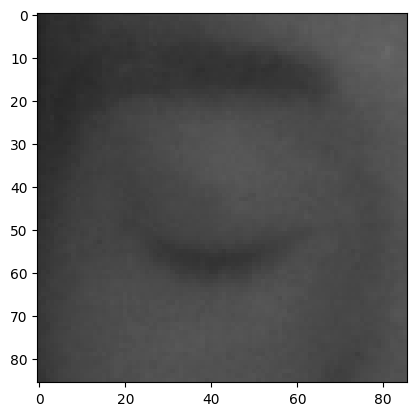

In [ ]:
plt.imshow(img_array)

In [ ]:
img_array.shape

(86, 86, 3)

## Convert data from BGR to RGB to fit mobileNet's input

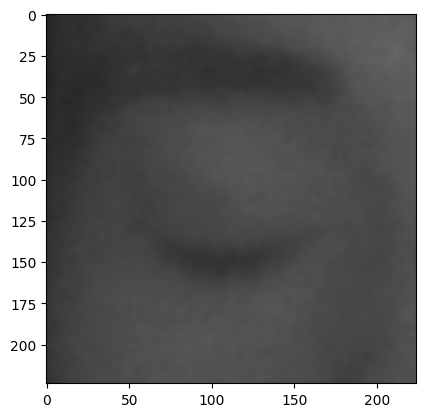

In [ ]:
img_size = 224
new_array = cv2.resize(img_array, (img_size,img_size))
plt.imshow(new_array, cmap="gray")
plt.show()

## Create training data 5000 images and valid data 625 images

In [ ]:
img_size = 224
Datadirectory = '../input/mrl-eye-dataset/data/train'
Classes = ['close eyes', 'open eyes']
training_data = []
valid_data = []

def create_training_valid_data(number):
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)
        count = 0
        for img in os.listdir(path):
            count += 1
            if count > number/2:
                if count > number/2 + 500: #626/2
                    break
                img_array = cv2.imread(os.path.join(path,img))
                backtorgb = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(backtorgb, (img_size,img_size))
                valid_data.append([new_array, class_num])
            else:
                img_array = cv2.imread(os.path.join(path,img))
                backtorgb = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(backtorgb, (img_size,img_size))
                training_data.append([new_array, class_num])

In [ ]:
create_training_valid_data(5000)
print(len(training_data))
print(len(valid_data))

5000
1000


In [ ]:
# Convert data to numpy array
X_train = []
Y_train = []
for features, label in training_data:
    X_train.append(features)
    Y_train.append(label)

X_train = np.array(X_train)
print(X_train.shape)
X_train = X_train.reshape(-1, img_size, img_size, 3)
print(f"X_train.shape: {X_train.shape}")
X_train = X_train/255.0
Y_train = np.array(Y_train)
print(f"Y_train.shape: {Y_train.shape}")

X_val = []
Y_val = []
# valid_data.pop() # 626 items reduce to 625
for features, label in valid_data:
    X_val.append(features)
    Y_val.append(label)

X_val = np.array(X_val)
print(X_val.shape)
X_val = X_val.reshape(-1, img_size, img_size, 3)
print(f"X_val.shape: {X_val.shape}")
X_val = X_val/255.0
Y_val = np.array(Y_val)
print(f"Y_val.shape: {Y_val.shape}")

count_zeros = np.count_nonzero(Y_train < 0.5)
print(count_zeros)
count_ones = np.count_nonzero(Y_train > 0.5)
print(count_ones)
count_zeros = np.count_nonzero(Y_val < 0.5)
print(count_zeros)
count_ones = np.count_nonzero(Y_val > 0.5)
print(count_ones)

(5000, 224, 224, 3)
X_train.shape: (5000, 224, 224, 3)
Y_train.shape: (5000,)
(1000, 224, 224, 3)
X_val.shape: (1000, 224, 224, 3)
Y_val.shape: (1000,)
2500
2500
500
500


In [ ]:
# import matplotlib.pyplot as plt
# # Create a new figure
# fig = plt.figure(figsize=(15, 20))


# for i in range(2475, 2525):
#     image = X_train[i]
#     label = Y_train[i]

#     # Create a subplot for this image
#     ax = fig.add_subplot(10, 5, i+1-2475)

#     # Show the image with the label
#     # Display the image
#     ax.imshow(image)

#     # Set the title as the prediction and label
#     ax.set_title(f'Label: {label}')

# # Show the plot
# plt.tight_layout()
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# # Create a new figure
# fig = plt.figure(figsize=(15, 20))


# for i in range(288, 338):
#     image = X_val[i]
#     label = Y_val[i]

#     # Create a subplot for this image
#     ax = fig.add_subplot(10, 5, i+1-288)

#     # Show the image with the label
#     # Display the image
#     ax.imshow(image)

#     # Set the title as the prediction and label
#     ax.set_title(f'Label: {label}')

# # Show the plot
# plt.tight_layout()
# plt.show()

## Data augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
   rotation_range=20,
   width_shift_range=0.2,
   height_shift_range=0.2,
   shear_range=0.2,
   zoom_range=0.2,
   horizontal_flip=True,
   fill_mode='nearest'
)
# train_datagen.fit(X_train)

# Train model

In [ ]:
base_model = keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    weights=None,
    include_top=False
)
# model.summary()

In [ ]:
x = base_model.output
# let's add a fully-connected layer
x = layers.Flatten()(x)
# and a logistic layer -- let's say we have 2 classes
predictions = layers.Dense(1, activation='sigmoid')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,320,705 (8.85 MB)

 Trainable params: 2,286,593 (8.72 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss="binary_crossentropy", optimizer = AdamW(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, weight_decay=0.01), metrics=['accuracy', 'precision', 'recall'])
# prepare model model saving directory
save_dir = os.path.join('/kaggle/working', 'saved_models')  # Use Kaggle working directory
model_name = 'MobileNetv2_model.{epoch:02d}.keras'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

from tensorflow.keras.callbacks import ModelCheckpoint
# prepare callbacks for model saving and for learning rate reducer
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
#Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
callbacks = [checkpoint, early_stopping]

In [ ]:
# history = model.fit(
#     train_datagen.flow(X_train, Y_train, batch_size=32),
#     epochs=50,
#     validation_data=(X_val, Y_val),
#     callbacks=[early_stopping]
# )
history = model.fit(X_train, Y_train, batch_size=4, epochs = 70, validation_data=(X_val, Y_val), callbacks=early_stopping)

Epoch 1/70
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.9748 - loss: 0.0705 - precision: 0.9761 - recall: 0.9737 - val_accuracy: 0.9190 - val_loss: 0.2562 - val_precision: 0.9284 - val_recall: 0.9080
Epoch 2/70
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.9760 - loss: 0.0975 - precision: 0.9761 - recall: 0.9762 - val_accuracy: 0.9670 - val_loss: 0.1143 - val_precision: 0.9795 - val_recall: 0.9540
Epoch 3/70
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.9834 - loss: 0.0465 - precision: 0.9851 - recall: 0.9813 - val_accuracy: 0.9170 - val_loss: 0.4236 - val_precision: 0.9064 - val_recall: 0.9300
Epoch 4/70
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.9839 - loss: 0.0498 - precision: 0.9849 - recall: 0.9831 - val_accuracy: 0.9660 - val_loss: 0.1234 - val_precision: 0.9775 - val_recall: 0.9540
Epoch 5/70
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.9847 - loss: 0.0427 - precision: 0.9878 - recall: 0.9817 - val_accuracy: 0

## Plot accuracy curve

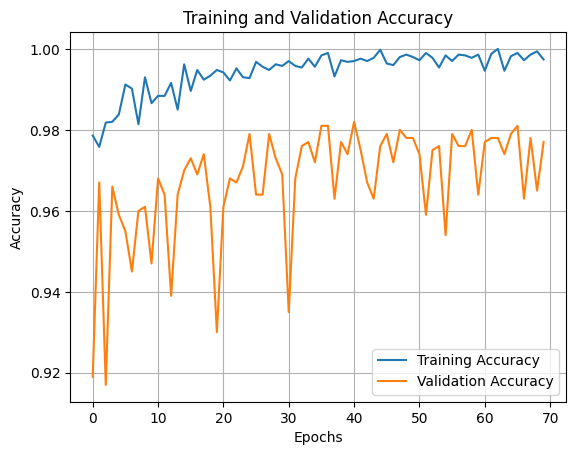

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(train_acc))  # Get the number of epochs

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Plot loss curve

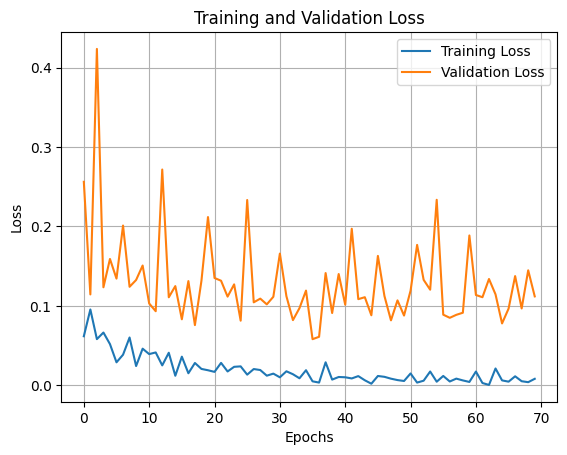

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_acc))  # Get the number of epochs

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Plot Precision, Recall, F1_score

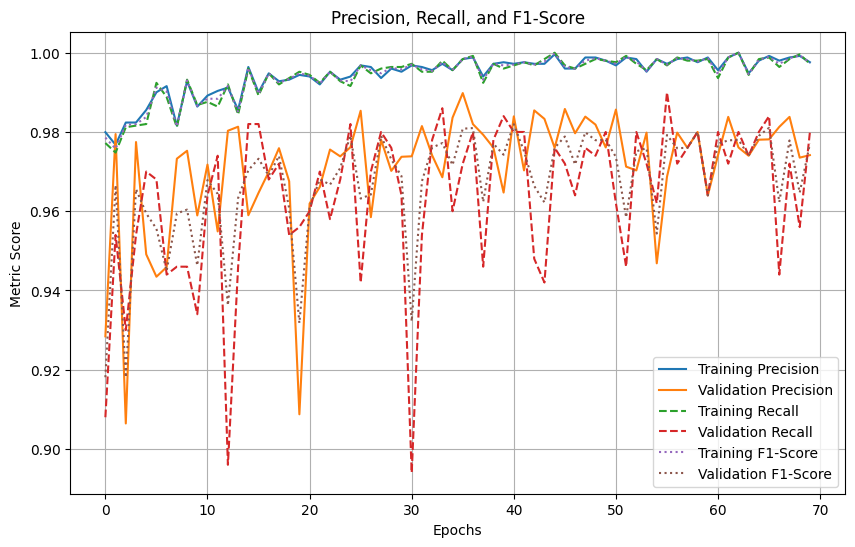

In [ ]:
# Assuming history contains metrics with these names
train_precision = history.history['precision']
val_precision = history.history['val_precision']
train_recall = history.history['recall']
val_recall = history.history['val_recall']
train_f1_score = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(train_precision, train_recall)]
val_f1_score = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(val_precision, val_recall)]

epochs = range(len(train_precision))  # Get the number of epochs

plt.figure(figsize=(10, 6))  # Set plot size for better visibility

# Plot precision
plt.plot(epochs, train_precision, label='Training Precision')
plt.plot(epochs, val_precision, label='Validation Precision')

# Plot recall on same plot with different line style
plt.plot(epochs, train_recall, label='Training Recall', linestyle='--')
plt.plot(epochs, val_recall, label='Validation Recall', linestyle='--')

# Plot F1-score on same plot with another line style
plt.plot(epochs, train_f1_score, label='Training F1-Score', linestyle='dotted')
plt.plot(epochs, val_f1_score, label='Validation F1-Score', linestyle='dotted')

plt.title('Precision, Recall, and F1-Score')
plt.xlabel('Epochs')
plt.ylabel('Metric Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save('my_model.h5')

# Load saved model for testing

## Load test data

In [ ]:
Datadirectory = '../input/mrl-eye-dataset/data/test'
Classes = ['close eyes', 'open eyes']

In [ ]:
Datadirectory = '../input/mrl-eye-dataset/data/test'
Classes = ['close eyes', 'open eyes']
test_data = []
def create_test_data(number):
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)
        count = 0
        for img in os.listdir(path):
            count += 1
            if count > (number+1)//2:
                break
            img_array = cv2.imread(os.path.join(path,img))
            backtorgb = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
            new_array = cv2.resize(backtorgb, (img_size,img_size))
            test_data.append([new_array, class_num])

In [ ]:
create_test_data(1000)
print(len(test_data))

2350


In [ ]:
X_test = []
Y_test = []
test_data.pop() # 626 items reduce to 625
for features, label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test)
print(X_test.shape)
X_test = X_test.reshape(-1, img_size, img_size, 3)
print(f"X_test.shape: {X_test.shape}")
X_test = X_test/255.0
Y_test = np.array(Y_test)
print(f"Y_test.shape: {Y_test.shape}")

(2349, 224, 224, 3)
X_test.shape: (2349, 224, 224, 3)
Y_test.shape: (2349,)


# Load model and evaluate model

In [ ]:
model1 = tf.keras.models.load_model('my_model.h5')

In [ ]:
model1.evaluate(X_test, Y_test)

74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.9891 - loss: 0.0502 - precision_1: 0.2094 - recall_1: 0.1988


[0.1715170294046402,
 0.9633886814117432,
 0.9661399722099304,
 0.8577154278755188]

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 5s/step


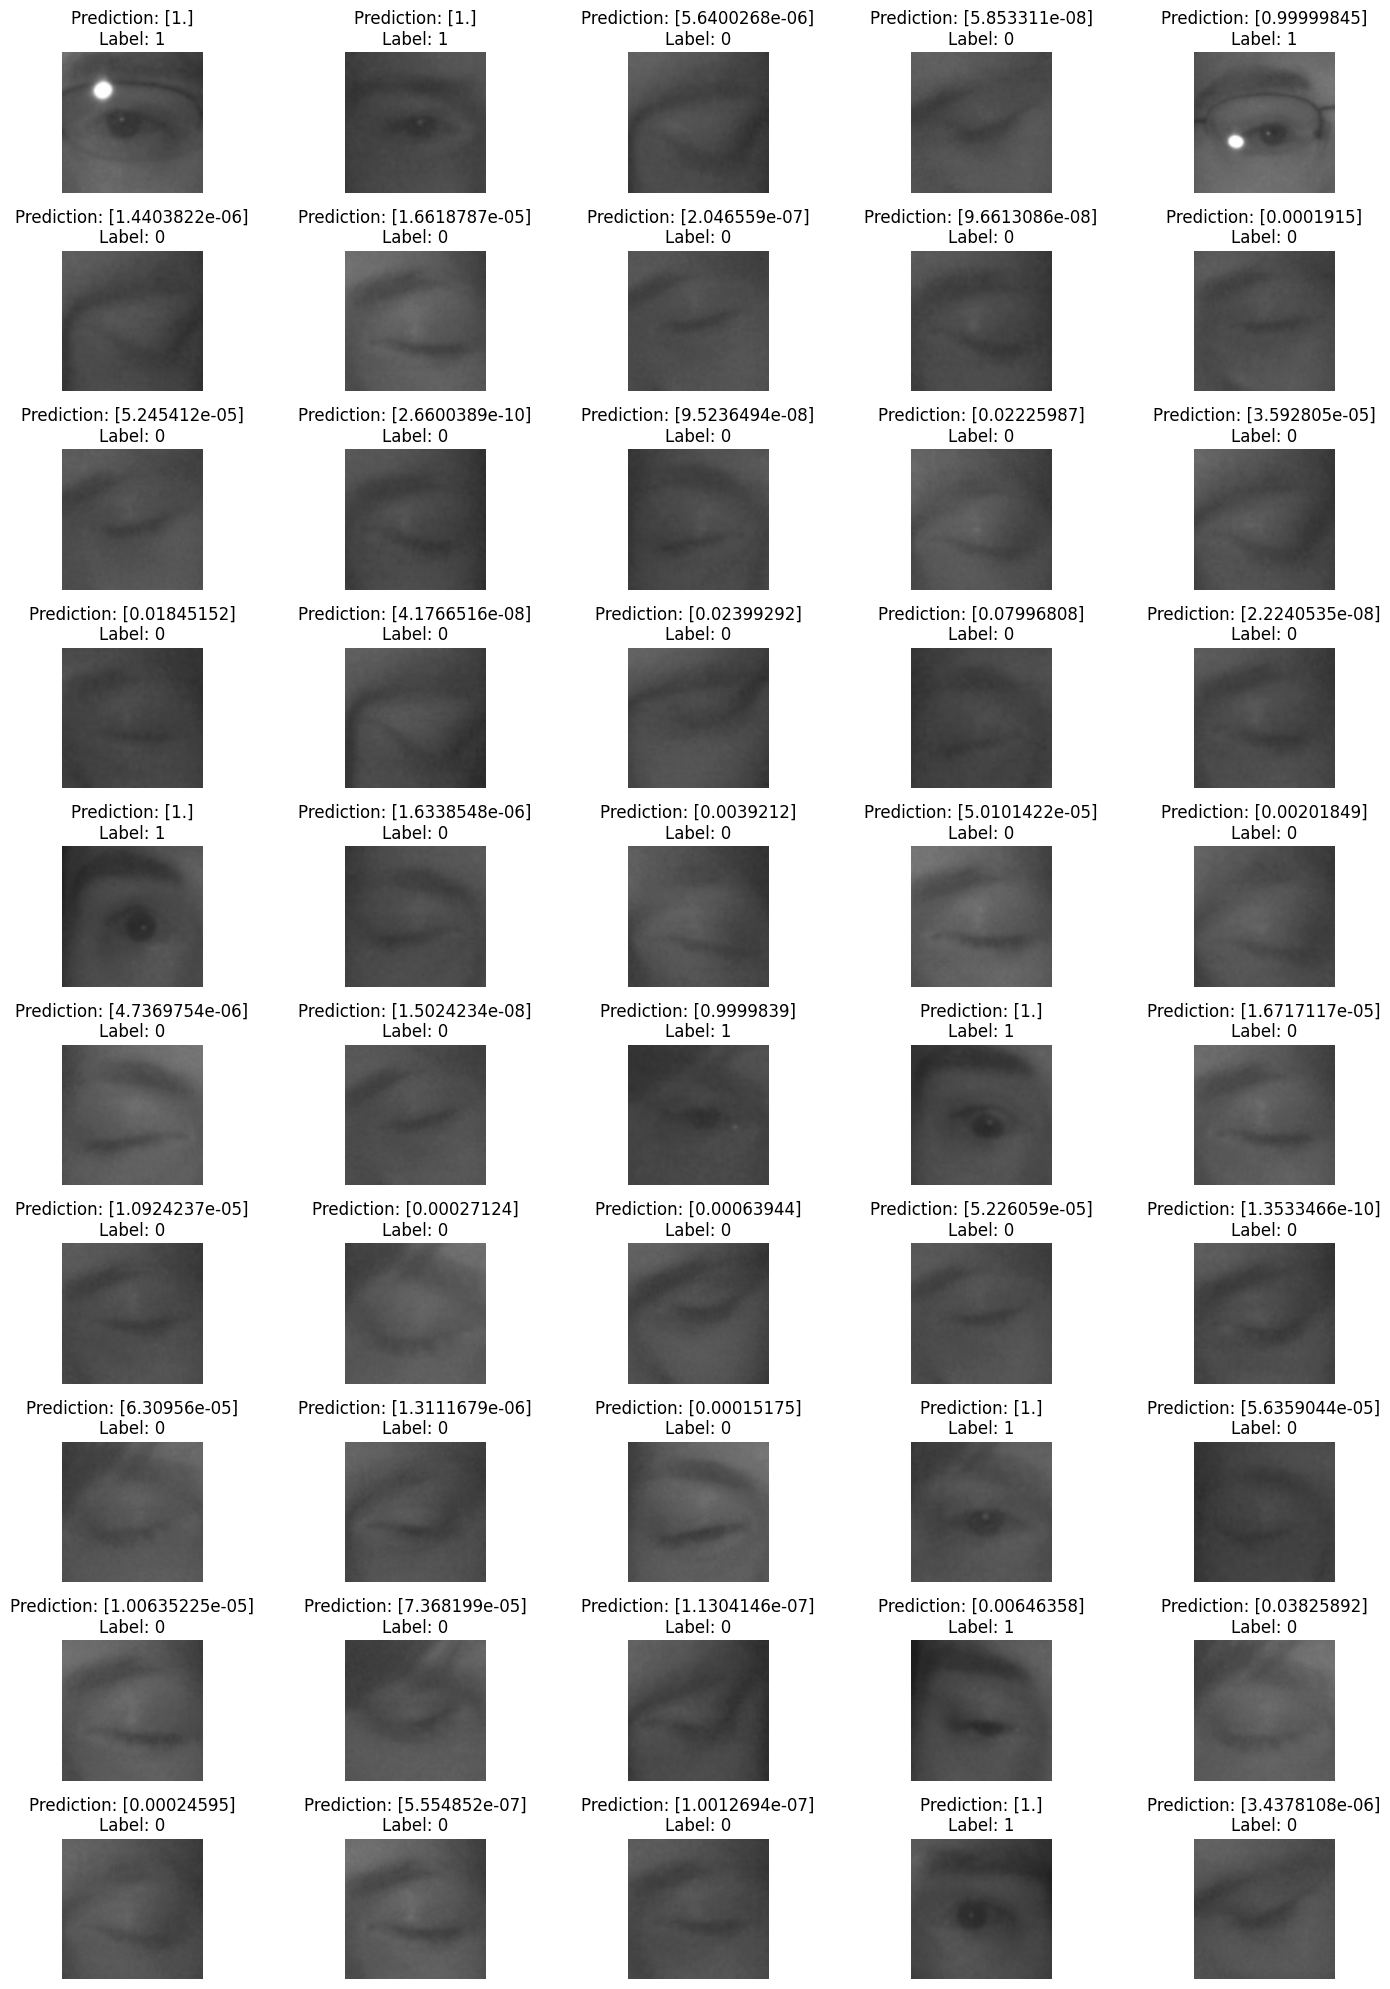

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_image_with_prediction(image, prediction, label, ax):

    # Display the image
    ax.imshow(image)
    ax.axis('off')

    # Set the title as the prediction and label
    ax.set_title(f'Prediction: {prediction}\nLabel: {label}')

# Create a new figure
fig = plt.figure(figsize=(15, 20))

# Assuming X_test and Y_test are your data and labels
indices = np.arange(X_test.shape[0])
np.random.shuffle(indices)

X_test = X_test[indices]
Y_test = Y_test[indices]
# Predict all images at once
predictions = model1.predict(X_test[:50])

for i in range(50):
    image = X_test[i]
    label = Y_test[i]
    prediction = predictions[i]

    # Create a subplot for this image
    ax = fig.add_subplot(10, 5, i+1)

    # Show the image with the prediction and label
    show_image_with_prediction(image, prediction, label, ax)

# Show the plot
plt.tight_layout()
plt.show()